In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

## CARGAR LOS DATOS

In [33]:
try:
    from apafib import load_BCN_sanciones
    sanciones_data = load_BCN_sanciones()
except:
    print("No se han podido cargar los datos")

In [34]:
categorical_columns = list(sanciones_data.dtypes[sanciones_data.dtypes == 'O'].index.values)
print("Variables Categoricas:", categorical_columns)


print(sanciones_data.columns)
sanciones_data.head()

Variables Categoricas: []
Index(['Sanciones-Numero', 'IBEX-IBEX',
       'Temperatura-Barcelona - Zona Universitària', 'TransitoHoras-Nit (0-5)',
       'TransitoHoras-Matí (6-13)', 'TransitoHoras-Tarda (14-19)',
       'TransitoHoras-Vespre (20-24)', 'VisitantesMunicipales-Badalona',
       'VisitantesMunicipales-L'Hospitalet de Llobregat',
       'VisitantesMunicipales-Sabadell',
       'VisitantesMunicipales-Santa Coloma de Gramenet',
       'VisitantesMunicipales-Terrassa', 'ContaminacionAcustica-19h',
       'ContaminacionAcustica-4h', 'ContaminantesEixample-Mitjana NO2'],
      dtype='object')


,Sanciones-Numero,IBEX-IBEX,Temperatura-Barcelona - Zona Universitària,TransitoHoras-Nit (0-5),TransitoHoras-Matí (6-13),TransitoHoras-Tarda (14-19),TransitoHoras-Vespre (20-24),VisitantesMunicipales-Badalona,VisitantesMunicipales-L'Hospitalet de Llobregat,VisitantesMunicipales-Sabadell,VisitantesMunicipales-Santa Coloma de Gramenet,VisitantesMunicipales-Terrassa,ContaminacionAcustica-19h,ContaminacionAcustica-4h,ContaminantesEixample-Mitjana NO2
Dia,,,,,,,,,,,,,,,
2022-05-13,3026.0,8338.1,19.13,1.201,2.026,2.214,1.698,74601.0,90449.0,20290.0,36932.0,24687.0,67.80,54.66,60.58
2022-05-14,1671.0,8343.3,21.52,1.213,1.759,1.803,1.695,61050.0,81027.0,19391.0,33755.0,23209.0,66.51,57.18,53.79
2022-05-15,1659.0,8348.5,22.32,1.264,1.545,1.814,1.651,54080.0,74599.0,16397.0,32933.0,21983.0,66.92,56.34,54.00
2022-05-16,2712.0,8353.7,22.25,1.262,2.031,1.962,1.607,73664.0,89460.0,18791.0,37181.0,24275.0,67.33,53.73,59.54
2022-05-17,2699.0,8475.7,21.95,1.237,2.148,2.124,1.563,72504.0,89622.0,20053.0,37182.0,24613.0,67.30,52.93,58.88


Como podemos observar haciendo un pequeño vistazo a los datos en general, nuestro conjunto no tiene ninguna variable categorica. Ademas se compone de 15 variables predictivas
siendo nuestro objetivo la primera variable que son el numeros de sanciones al dia.

### Visualizacion de los datos

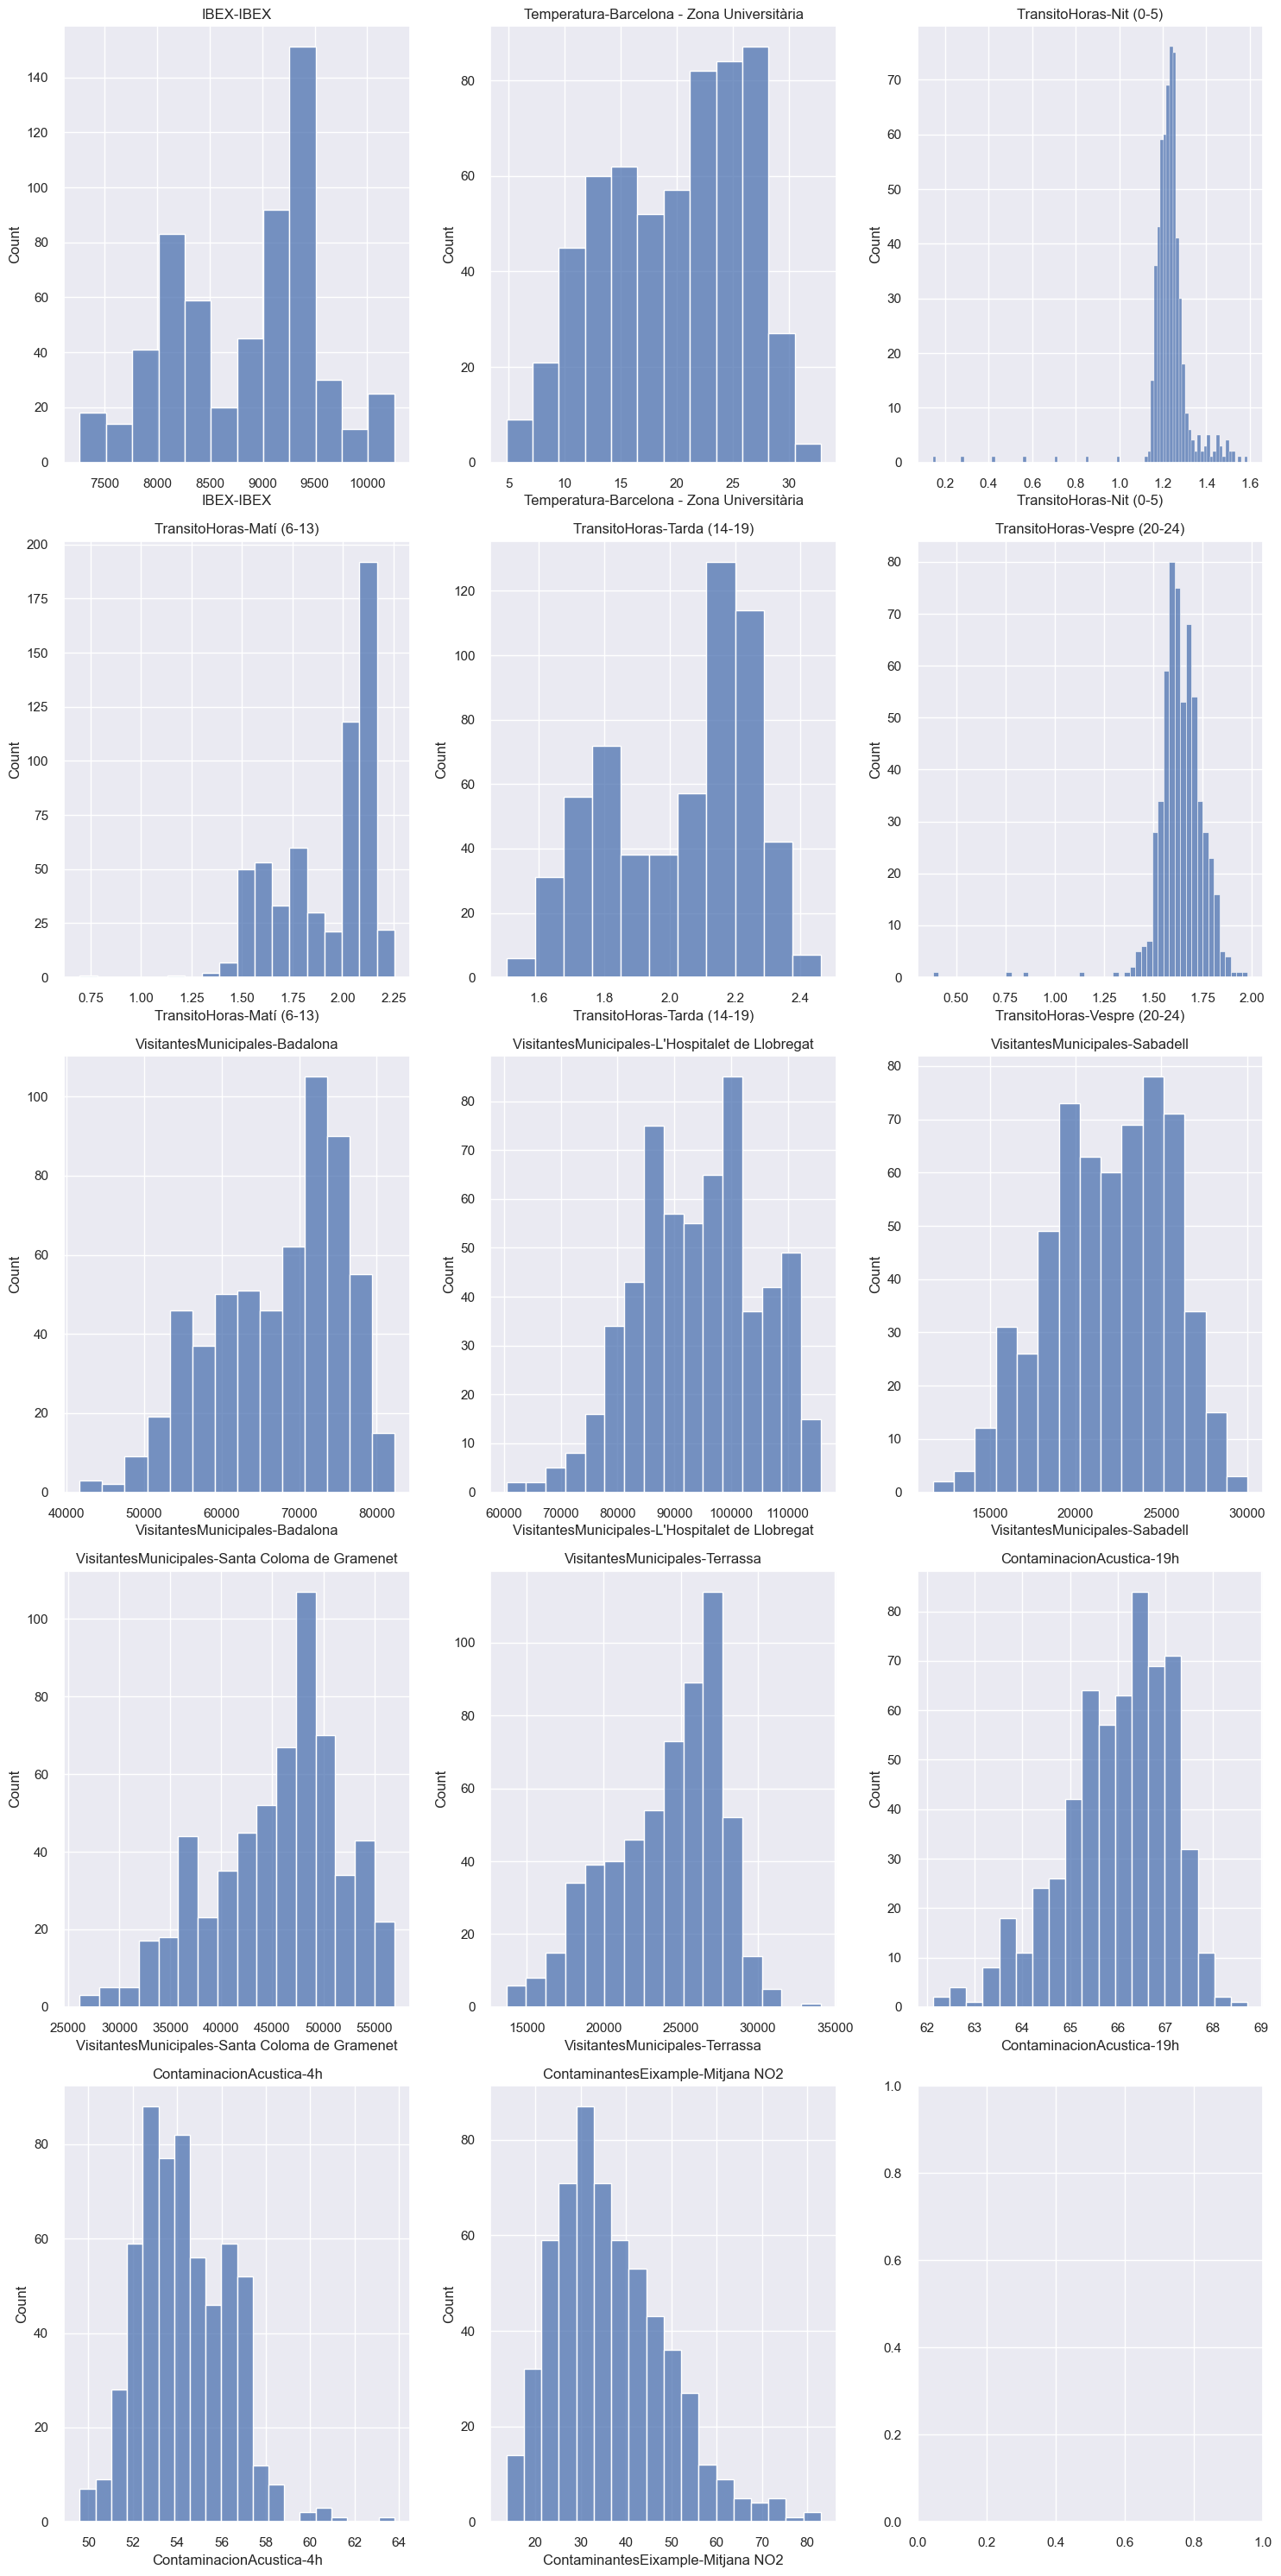

In [35]:
fig, axes = plt.subplots(5,3,figsize=(15,30))

# We will not plot country because it has too many categories.
for i, c in enumerate(sanciones_data.columns[1:]):
    ax = axes.reshape(-1)[i]
    if sanciones_data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=sanciones_data,ax=ax)
    else:
        b = sns.histplot(x=c,data=sanciones_data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

In [36]:
sanciones_data.shape

sanciones_data.isna().sum().sort_values(ascending=False)

(590, 15)

Sanciones-Numero                                   0
IBEX-IBEX                                          0
Temperatura-Barcelona - Zona Universitària         0
TransitoHoras-Nit (0-5)                            0
TransitoHoras-Matí (6-13)                          0
TransitoHoras-Tarda (14-19)                        0
TransitoHoras-Vespre (20-24)                       0
VisitantesMunicipales-Badalona                     0
VisitantesMunicipales-L'Hospitalet de Llobregat    0
VisitantesMunicipales-Sabadell                     0
VisitantesMunicipales-Santa Coloma de Gramenet     0
VisitantesMunicipales-Terrassa                     0
ContaminacionAcustica-19h                          0
ContaminacionAcustica-4h                           0
ContaminantesEixample-Mitjana NO2                  0
dtype: int64

Aqui acabamos de comprovar que nuestra data no tiene valores perdidos

# APARTADO A. DIVISION DEL CONJUNTO  DE DATOS Y PEQUEÑA EXPLORACION

In [37]:
X = sanciones_data.loc[:,sanciones_data.columns != 'Sanciones-Numero']
y = sanciones_data['Sanciones-Numero']


Como hemos dicho previamente todas las varibles son numericas y admeas si nos fijamos vemos que no tenemos valores perdidos con lo que no hace falta hacer un preprocesado de los datos para mas tarde aplicar la lineal regression. Pero para que la regression nos de buenos resutltados y los pesos de esta sean convincente, vamos a escalar nuestros datos. De esta forma, todas las variables tendrán el mismo rango y aprovecharemos mejor nuestros modelos.


In [38]:
def scaling_preprocessing(X, y, scaler=None):
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    
    # Escalamos las variables numericas
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    if scaler is None: 
        # Generamos el scaler cuando los datos son los de entrenamiento
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    return X, y, scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, y_train, scaler = scaling_preprocessing(X_train,y_train)
X_test, y_test, _ = scaling_preprocessing(X_test,y_test,scaler)

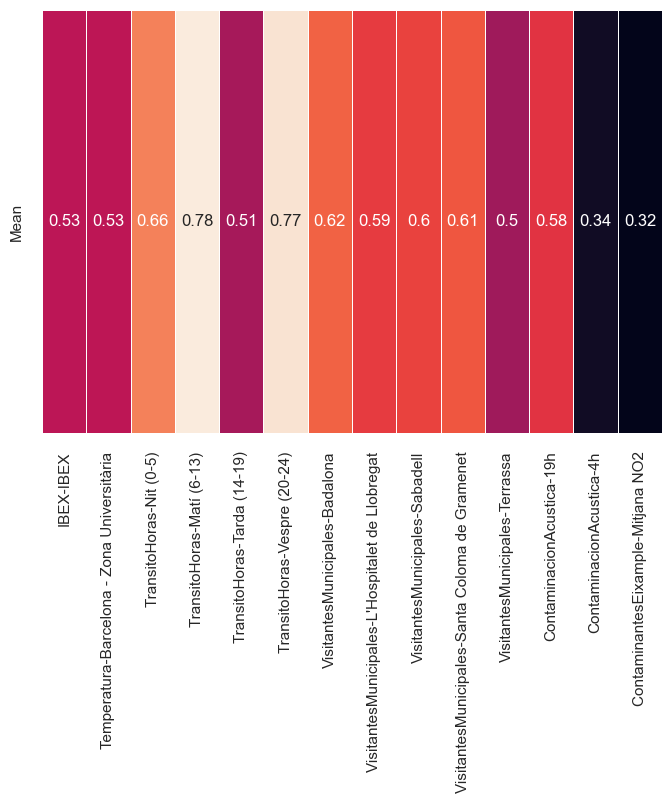

In [39]:
figsize = (20,1)
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Gracias al escalado el rango de nuestras variables es bastante razonable

Para acabar de ver las relaciones entre las variables imprimiremos la matriz de correlacion para saber que variables pueden llegasr a influir en nuestra variable objectivo.

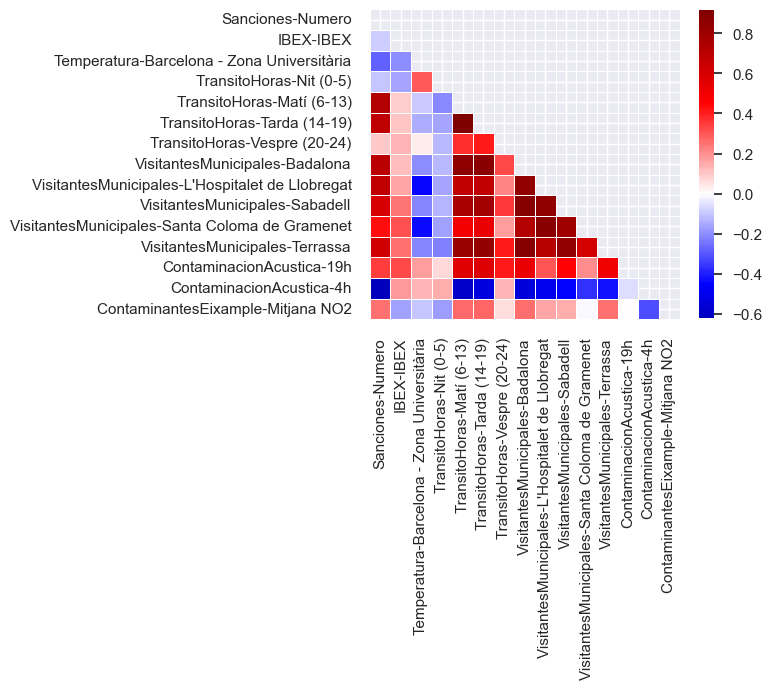

In [40]:
corr = sanciones_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(5, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Si observamos detenidamente la matriz de correlaciones podemos observar que bastantes correlaciones entre nuestras variables. Si nos centramos en nuestra variable objetivo, es decir en el numero de sanciones (Sanciones-Numero) vemos que presente una correlacion positiva muy fuerte con el numero de visitantes de los diferentes municipios, con el transito por la mañana y por la tarde y con la contaminación acustica. Este tiene basante logica ya cuantos más visitantes tiene un municipio más coches llegan y en proporción más sanciones se ponen. Ademas tiene logica que este fuertemente correlacionada con el transito por la mañana y por la tardee ya que es cuando más movimiento de coches hay y tambien es logico que cuanto más contaminación acustica más sanciones haya ya que podemos deducir que gran parte de esta contaminación esta generada por los vehiculos. Aun así hay algunas relaciones curiosas con nuestra variable objetivo. Hemos dicho que la contaminación acustica estaba relacionada de forma positiva con el numero de sanciones. Esto es cierto si nos fijamos en la variable que muestra la contaminacion a las 19. En cambio la variable que muestra la contaminación a las 4 de la mañana esta relacionada negativamente con nuestra variable objetivo. Esto podría indicar que en días donde el ruido nocturno es más alto, hay una ligera disminución en las sanciones diurnas. Es posible que esto refleje que las sanciones son menos comunes en días de alta actividad nocturna tambien. Por otro lado vemos que igual que hay una relacion positiva con el transito en ciertas horas, en el mediodia esta relacion no es tan fuerte sino que es más cercana a 0, al igual que durante la noche que la relacion aunque negativa se aproxima a 0. El resto de variables no tienen una gran relacion, o una muy fuerte, con nuestra variable objetivo.

Por otro lado algunas relaciones que podemos observar entre las varibles sin incluir nuestra objetivo son:
- La varibles similares como los visitantes de los municipios y el transito estan fuertemente relacionadas de forma positiva entre las de su mismo grupo.
- Visitantes y trafico relacionadas positvamente
- La contaminacion esta relacionada positivamente con el trafico y los visitantes, muy positivamente si hablamos de la contaminacion acustica a las 19 y negativamente si hablamos de la contaminacion acustica a las 4.
- La media de NO2 parece no tener ninguna relacion sumamente fuerte o importante con alfuan de las otras variables.

# APARTADO 2. REGRESION LINEAL RIDGE Y LASSO

In [41]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

linear_model = LinearRegression().fit(X_train, y_train)
r2_lr_train = linear_model.score(X_train, y_train)
r2_lr_cv = np.mean(cross_val_score(linear_model, X_train, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lr_train, r2_lr_cv))

Train R2 score: 0.7528488512016821
Cross-Validation R2 score: 0.6966147826243322


In [42]:
ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)

r2_ridge_train = ridge_cv.score(X_train, y_train)
r2_ridge_cv = np.mean(cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_ridge_train, r2_ridge_cv))

Train R2 score: 0.7483882189941156
Cross-Validation R2 score: 0.7021210943593695


In [43]:
lasso_cv = LassoCV(alphas=lambdas, cv = 5).fit(X_train, y_train)

r2_lasso_train = lasso_cv.score(X_train, y_train)
r2_lasso_cv = np.mean(cross_val_score(lasso_cv, X_train, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lasso_train, r2_lasso_cv))

Train R2 score: 0.7509198847227031
Cross-Validation R2 score: 0.7032752280721273


Haciendo una primera ejecucion de los modelos con los datos de entrenamiento vemos que el resultado no es malo. Podriamos decir que no es el mejor resultado posible pero que estamos obteniendo un resultado suficientemente decente para decir que no es malo. Si nos fijamos los 3 modelos obtenien mas o menos el mismo resultado tanto en la ejecucion indiviudal como en la de cross validation. A continuacion reprentaremos los valores de la variable objetivo para el conjunto de test contra las predicciones para observar los residuos.

In [44]:
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_name} - MSE: {mse:.3f}, R2: {r2:.3f}')
    return mse, r2

In [45]:
y_pred_linear = linear_model.predict(X_test)
y_pred_ridge = ridge_cv.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)

evaluate_model(y_test, y_pred_linear, "Regresion Lineal")
evaluate_model(y_test, y_pred_ridge, "Ridge")
evaluate_model(y_test, y_pred_lasso, "Lasso")

Regresion Lineal - MSE: 192315.555, R2: 0.656


(np.float64(192315.55488381136), 0.6556840105003197)

Ridge - MSE: 192553.239, R2: 0.655


(np.float64(192553.23866575595), 0.6552584686006135)

Lasso - MSE: 191442.449, R2: 0.657


(np.float64(191442.44890595903), 0.6572471932022281)

De primeras antes de hacer el plot de los residuos y de observar estos, nos damos cuenta de que usando el conjunto de test el R2 ha disminuido un poco. Esto se puede deber al hecho de que cuando hemos ejecutado la prueba con el conjunto de datos, el modelo ha memorizado un poco este conjunto, clasificando instancias que ya conocia. Cuando le hemos dado datos totalmente nuevos para el hemos obtenido resultados peores, no mucho pero peores. Aunque siguen siendo resultados que podriamos considerar decentes.

### PLOT PREDICCION VS REAL

<Figure size 1200x1500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales - Regresión Lineal')

<Axes: >

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales - Regresión Ridge')

<Axes: >

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales - Regresión LASSO')

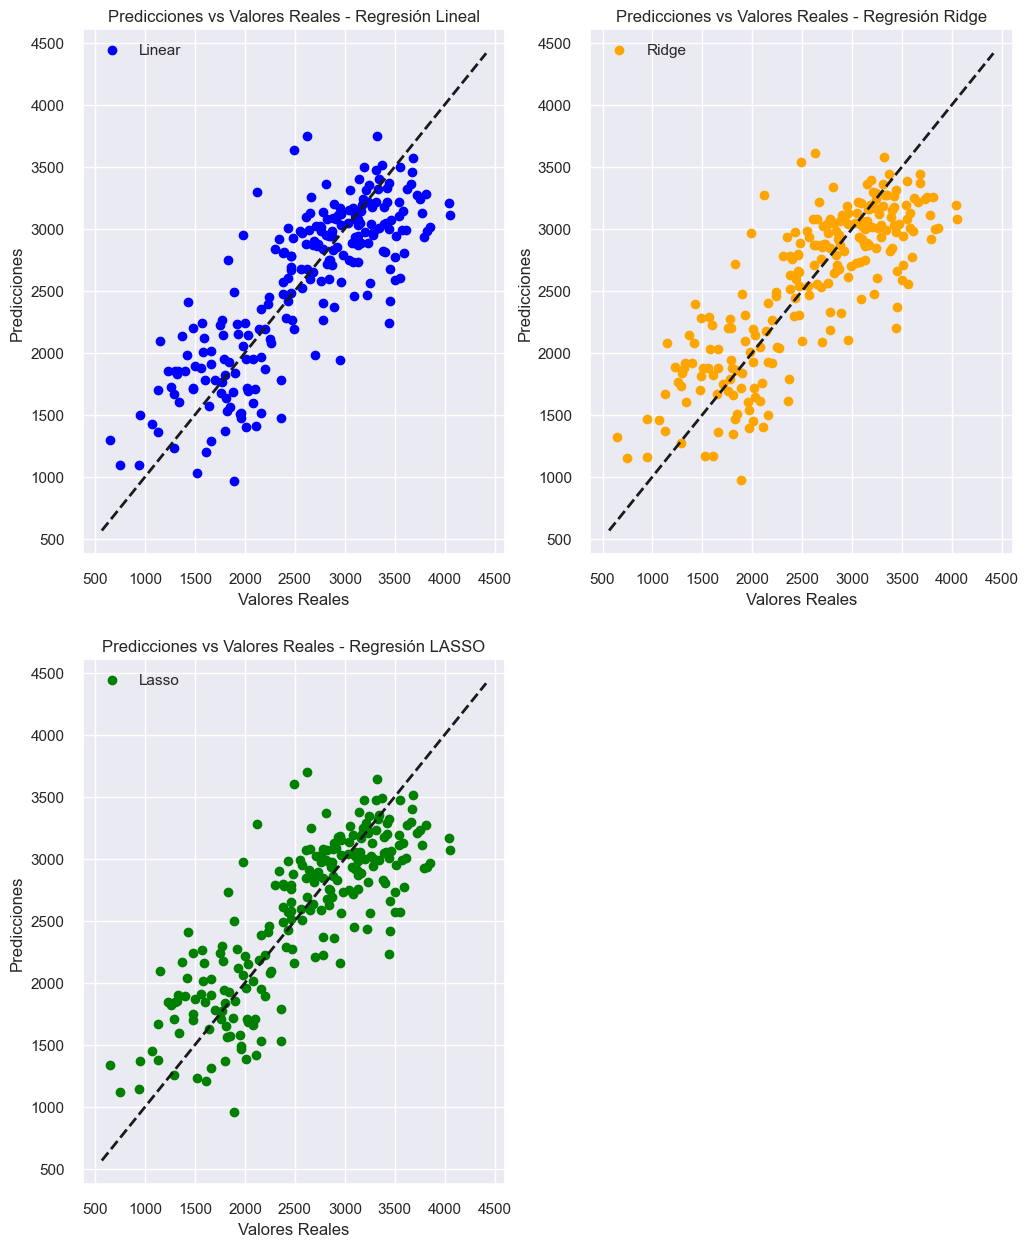

In [46]:
plt.figure(figsize=(12,15))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión Lineal')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_ridge, color='orange', label='Ridge')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión Ridge')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_lasso, color='green', label='Lasso')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión LASSO')
plt.legend()

plt.show()

Observando el los plots de los diferentes modelos de los valores que han predicho contra los valores reales, vemos de primeras una nube de puntos que se compone entorno a la recta que representa la igualdad entre los valores predichos y los reales. Ninguno de los tres modelos ajusta predice exageradamente bien los valores, ya que observamos que las graficas son bastante similares. Puede que si tuvieramos que decir que modelo es mejor podriamos decir que viendo los plots Ridge se comporta un poco mejor. Ya que si nos fijamos es el que ajusta un poco mejor sobre la recta. Pero como hemos comentado no hay una clarisima diferencia entre los modelos.

### PLOT DE RESIDUOS

<Figure size 1000x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='Sanciones-Numero', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de Residuos')

Text(0.5, 0, 'Residuos')

Text(0, 0.5, 'Frecuencia')

<Axes: >

<Axes: xlabel='Sanciones-Numero', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de Residuos')

Text(0.5, 0, 'Residuos')

Text(0, 0.5, 'Frecuencia')

<Axes: >

<Axes: xlabel='Sanciones-Numero', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de Residuos')

Text(0.5, 0, 'Residuos')

Text(0, 0.5, 'Frecuencia')

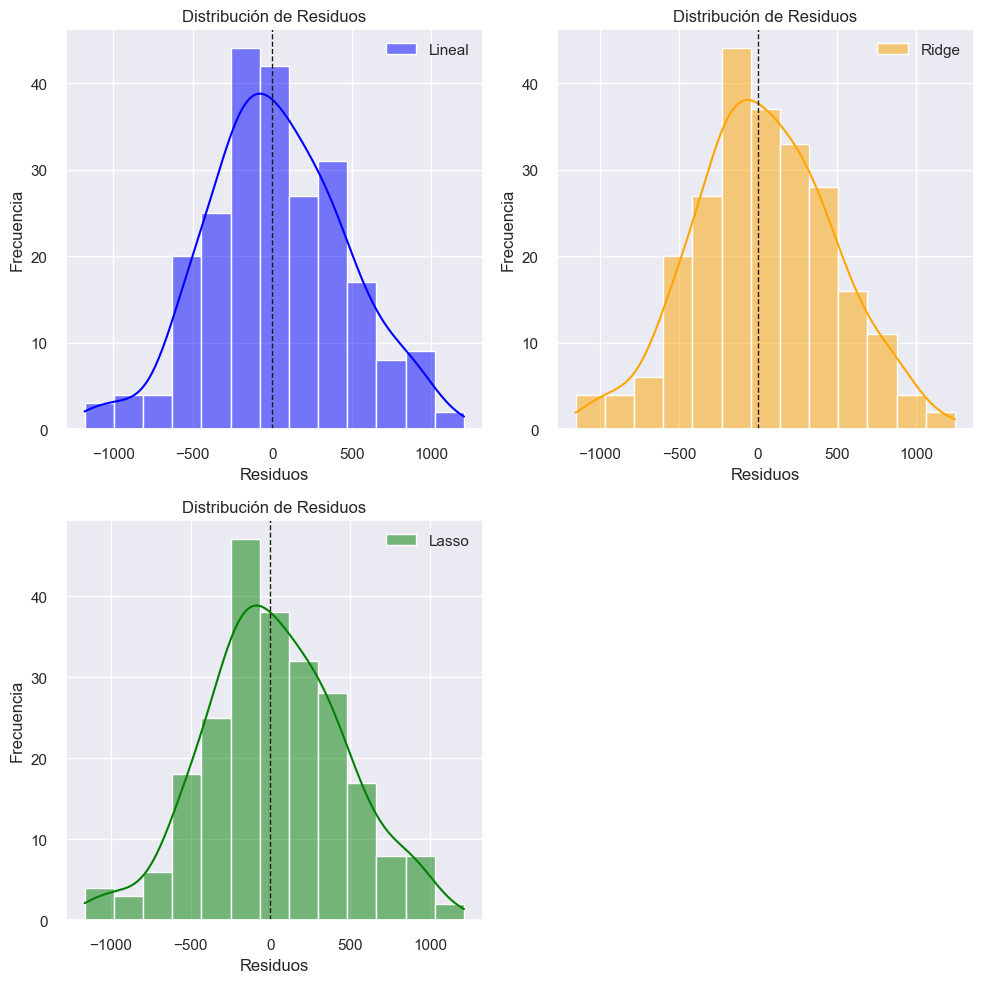

In [47]:
residuals_linear = y_test - y_pred_linear
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
sns.histplot(residuals_linear, kde=True, color='blue', label='Lineal', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(residuals_ridge, kde=True, color='orange', label='Ridge', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(2, 2, 3)
sns.histplot(residuals_lasso, kde=True, color='green', label='Lasso', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

A primea vista si observamos el plot de los residuos lo que podemos comentar es que parece que siguen una distribucion normal en los tres modelos. Tienen algun pico que se sale un poco de esta distribución pero a grandes rasgos se trata de una distribucion normal.

<Figure size 400x400 with 0 Axes>

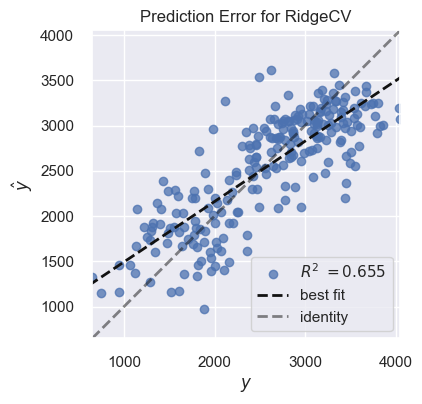

<Figure size 1000x1000 with 0 Axes>

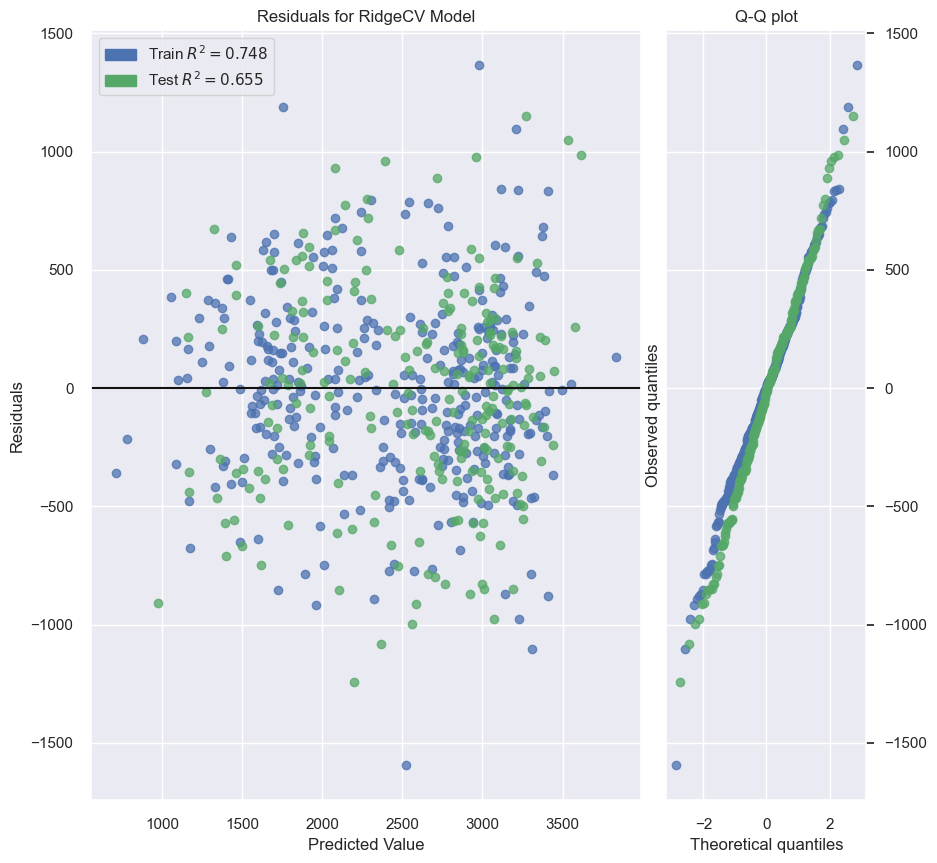

In [48]:
from yellowbrick.regressor import residuals_plot, prediction_error
plt.figure(figsize=(4,4))
visualizer = prediction_error(ridge_cv, X_test, y_test, is_fitted=True)

plt.figure(figsize=(10,10))
viz = residuals_plot(ridge_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)

<Figure size 400x400 with 0 Axes>

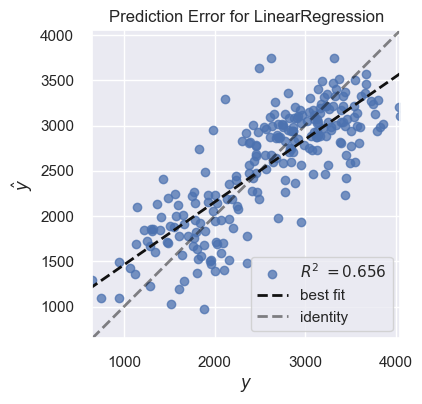

<Figure size 1000x1000 with 0 Axes>

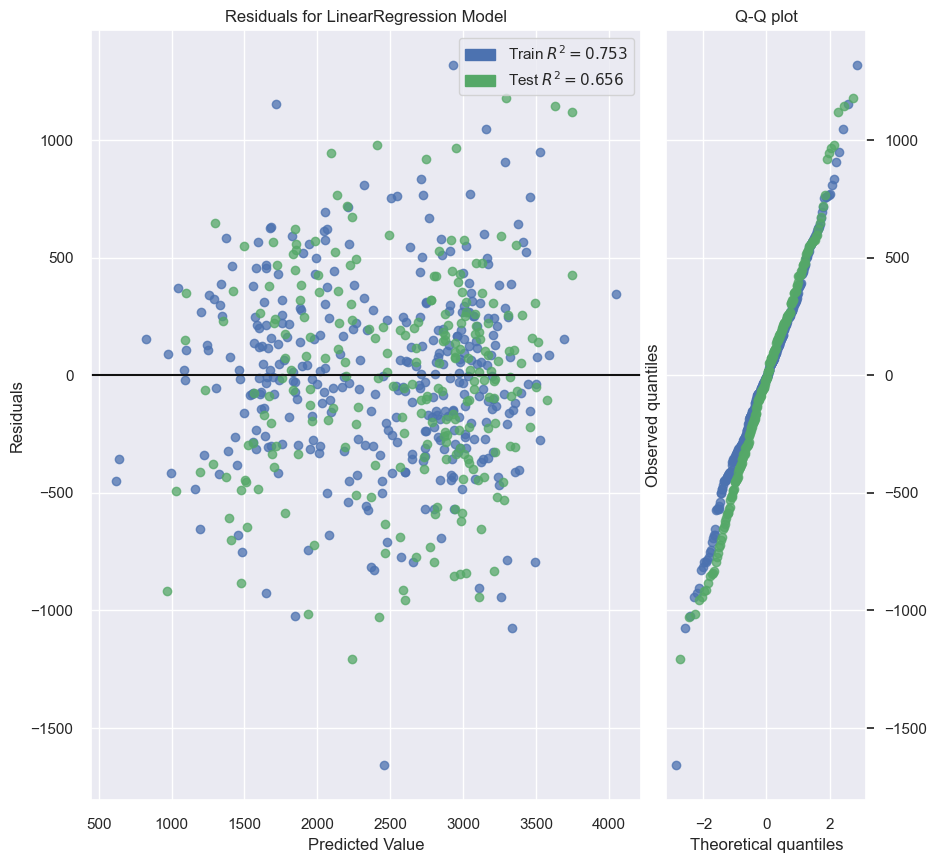

In [49]:
from yellowbrick.regressor import residuals_plot, prediction_error
plt.figure(figsize=(4,4))
visualizer = prediction_error(linear_model, X_test, y_test, is_fitted=True)

plt.figure(figsize=(10,10))
viz = residuals_plot(linear_model, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)

<Figure size 400x400 with 0 Axes>

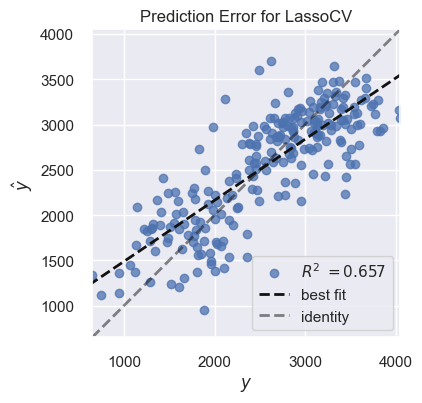

<Figure size 1000x1000 with 0 Axes>

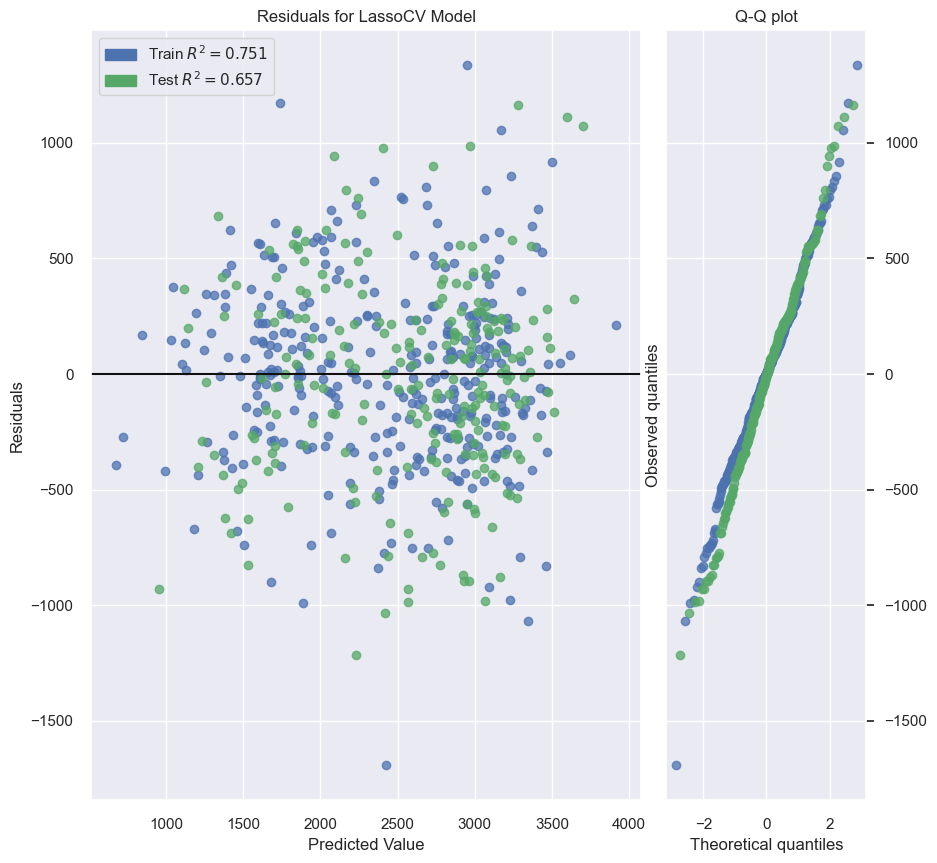

In [50]:
from yellowbrick.regressor import residuals_plot, prediction_error
plt.figure(figsize=(4,4))
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True)

plt.figure(figsize=(10,10))
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)

Mirando las graficas de los residuos i el qqplot de los diferentes modelos, vemos que los tres tienen un comportamineto muy similar. Parecen ajustarse relativamente bien a los datos con un desempeño decente tanto en el conjunto de entrenamineto como en el de prueba (Son un obvio descenso de R^2 en los datos de prueba, lo cual es esperable). En ninguno de los tres modelos la grafica de residuos muestra patrones claros, lo cual podria ser positivo para un modelo de regresion. Por ultimo la gráfica Q-Q muestra que los residuos se distribuyen aproximadamente de manera normal, aunque con algunas desviaciones en los extremos, lo cual podría ser una indicación de valores atípicos (outliers) o de cierta falta de homocedasticidad.

In [51]:
# Variables descartadas por LASSO
lasso_coef = lasso_cv.coef_
discarded_features = [sanciones_data.columns[i] for i in range(len(lasso_coef)) if lasso_coef[i] == 0]
print(f'Variables descartadas por LASSO: {discarded_features}')

Variables descartadas por LASSO: ['TransitoHoras-Vespre (20-24)', "VisitantesMunicipales-L'Hospitalet de Llobregat"]


Las variables descartadas por lasso son el transito entre las 20 y las 24 y los visitantes de Hospitalet de Llobregat

Si tuviera que decantarme por un modelo seria dificil, ya que los tres tienen un comportamiento muy similar pero probablemente escogeria LASSO o RIDGE al estar regularizados.

## APARTADO C OLS 

In [52]:
import statsmodels.api as sm

X_train_ols = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_ols)

result = ols_model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Sanciones-Numero   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     73.76
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           8.78e-94
Time:                        11:08:10   Log-Likelihood:                -2612.4
No. Observations:                 354   AIC:                             5255.
Df Residuals:                     339   BIC:                             5313.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                            1740.5493    360.807      4.824      0.000    1030.846    2450.252
IBEX-IBEX                                        -408.9976    123.412     -3.314      0.001    -651.748    -166.247
Temperatura-Barcelona - Zona Universitària       -712.4678    137.065     -5.198      0.000    -982.072    -442.864
TransitoHoras-Nit (0-5)                           708.3267    309.384      2.289      0.023      99.772    1316.881
TransitoHoras-Matí (6-13)                         807.2441    378.685      2.132      0.034      62.375    1552.113
TransitoHoras-Tarda (14-19)                       111.3042    247.516      0.450      0.653    -375.556     598.165
TransitoHoras-Vespre (20-24)                     -678.2600    307.975     -2.202      0.028   -1284.042     -72.478
VisitantesMunicipales-Badalona                    -54.8099    408.419     -0.134      0.893    -858.165     748.545
VisitantesMunicipales-L'Hospitalet de Llobregat  2374.0324    317.040      7.488      0.000    1750.420    2997.645
VisitantesMunicipales-Sabadell                   -175.3226    309.205     -0.567      0.571    -783.525     432.880
VisitantesMunicipales-Santa Coloma de Gramenet  -1609.7936    271.922     -5.920      0.000   -2144.660   -1074.927
VisitantesMunicipales-Terrassa                    850.8813    324.144      2.625      0.009     213.294    1488.469
ContaminacionAcustica-19h                         803.6172    207.683      3.869      0.000     395.108    1212.127
ContaminacionAcustica-4h                        -1367.8389    234.505     -5.833      0.000   -1829.107    -906.570
ContaminantesEixample-Mitjana NO2                -111.4767    142.726     -0.781      0.435    -392.217     169.263
==============================================================================
Omnibus:                        9.554   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.584
Skew:                           0.090   Prob(JB):                     0.000250
Kurtosis:                       4.045   Cond. No.                         61.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Si analizamos la significatividad que asigna al modelo al coeficiente de cada variable observamos que hay 4 variables que podriamos considerar no significativas. Estas son:
- TransitoHoras-Tarda (14-19)
- VisitantesMunicipales-Badalona
- VisitantesMunicipales-Sabadell
- ContaminantesEixample-Mitjana NO2

Resulta sorprendente que alguna de estas variables sea no relevante que de primeras por ejemplo podriamos pensar que el Transito por la tarde tiene una gran relacion con el numero de sanciones que se ponen. O por ejemplo los visitantes en badalona y sabadell tampoco tienen relacion y lo logica es pensar que si tienen un peso e influencia en el numero de sanciones. Por ultimo la media de NO2 puede no ser relevante debido a la procedencia de estos contaminantes que no tiene poruqe ser debido a la contaminacion por automoviles, es decir al uso de vehiculos.

In [53]:
significant_vars = result.pvalues[result.pvalues < 0.05].index.tolist()
if 'const' in significant_vars:
    significant_vars.remove('const')

print(significant_vars)


X_train_significant = X_train[significant_vars]
X_test_significant = X_test[significant_vars]

ridge_cv_ols = RidgeCV(alphas=lambdas, cv=5).fit(X_train_significant, y_train)

r2_ridge_train_ols = ridge_cv_ols.score(X_train_significant, y_train)
r2_ridge_cv_ols = np.mean(cross_val_score(ridge_cv_ols, X_train_significant, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_ridge_train_ols, r2_ridge_cv_ols))



y_pred_ridge_ols = ridge_cv_ols.predict(X_test_significant)



evaluate_model(y_test, y_pred_ridge_ols, "Ridge")


['IBEX-IBEX', 'Temperatura-Barcelona - Zona Universitària', 'TransitoHoras-Nit (0-5)', 'TransitoHoras-Matí (6-13)', 'TransitoHoras-Vespre (20-24)', "VisitantesMunicipales-L'Hospitalet de Llobregat", 'VisitantesMunicipales-Santa Coloma de Gramenet', 'VisitantesMunicipales-Terrassa', 'ContaminacionAcustica-19h', 'ContaminacionAcustica-4h']
Train R2 score: 0.7486244611811279
Cross-Validation R2 score: 0.7158522513762695
Ridge - MSE: 193328.611, R2: 0.654


(np.float64(193328.61126594013), 0.653870264800746)

Los resultados nuevos son exactamente los mismos que sin eliminar las variables no relevantes. Esto puede ser debido a que si esas variables no aportan información relevante o si su efecto en la predicción es mínimo no veremos cambios significativos, ademas podemos fijarnos en que los coeficientes de estas variables son cercanos a 0 o mucho menores que los coeficientes de las otras variables.

# APARTADO D NUEVAS VARIABLES

Vamos a usar a la función PolynomialFeatures de
scikit-learn para añadir características al conjunto de datos que correspondan a polinomios de grado 2

In [54]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

linear_model = LinearRegression().fit(X_train_poly, y_train)
r2_lr_train = linear_model.score(X_train_poly, y_train)
r2_lr_cv = np.mean(cross_val_score(linear_model, X_train_poly, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lr_train, r2_lr_cv))

ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(X_train_poly, y_train)

r2_ridge_train = ridge_cv.score(X_train_poly, y_train)
r2_ridge_cv = np.mean(cross_val_score(ridge_cv, X_train_poly, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_ridge_train, r2_ridge_cv))

lasso_cv = LassoCV(alphas=lambdas, cv = 5).fit(X_train_poly, y_train)

r2_lasso_train = lasso_cv.score(X_train_poly, y_train)
r2_lasso_cv = np.mean(cross_val_score(lasso_cv, X_train_poly, y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lasso_train, r2_lasso_cv))

Train R2 score: 0.8911077602204385
Cross-Validation R2 score: 0.1881452437028006
Train R2 score: 0.836028960560272
Cross-Validation R2 score: 0.7623109712094471
Train R2 score: 0.8566470683731129
Cross-Validation R2 score: 0.7485299485081263


A simple vista y ejecutando los diferentes modelos con el conjunto de prurbas vemos que el score a aumentado, en general sobretodo en los metodos que no usan validacion cruzada. Esto puede ser debido a que gracias a haber añadido nuevas caracteristicas que corresponden a polinomios de grado 2 estemos explicando relaciones de las variables que son importantes que con las varaibles de manera individual no conseguiamos explicar. Detenidamente nos fijamos en que la linear regression usando cross validation ha sido la unica ejucion de los modelos que ha obtenido un resultado muy muy malo. 

A continuacion reprensentaremos las predicciones respecto a los valores reales como hemos hecho en el apartado b.

In [55]:
y_pred_linear = linear_model.predict(X_test_poly)
y_pred_ridge = ridge_cv.predict(X_test_poly)
y_pred_lasso = lasso_cv.predict(X_test_poly)

evaluate_model(y_test, y_pred_linear, "Regresion Lineal")
evaluate_model(y_test, y_pred_ridge, "Ridge")
evaluate_model(y_test, y_pred_lasso, "Lasso")

Regresion Lineal - MSE: 917649.551, R2: -0.643


(np.float64(917649.5506170327), -0.6429321758478179)

Ridge - MSE: 143807.707, R2: 0.743


(np.float64(143807.7070515224), 0.7425310033759875)

Lasso - MSE: 157433.956, R2: 0.718


(np.float64(157433.95612793294), 0.7181349765608507)

Observamos que los resultados de la regresion lineal son muy malos, en cambio los de Ridge y Lasso han mejorado con respecto a los resultado que hemos visto en el apartado b, en los que no hemos usado la función PolynomialFeatures.

### PLOT PREDICCION VS REAL

<Figure size 1200x1500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales - Regresión Lineal')

<Axes: >

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales - Regresión Ridge')

<Axes: >

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales - Regresión LASSO')

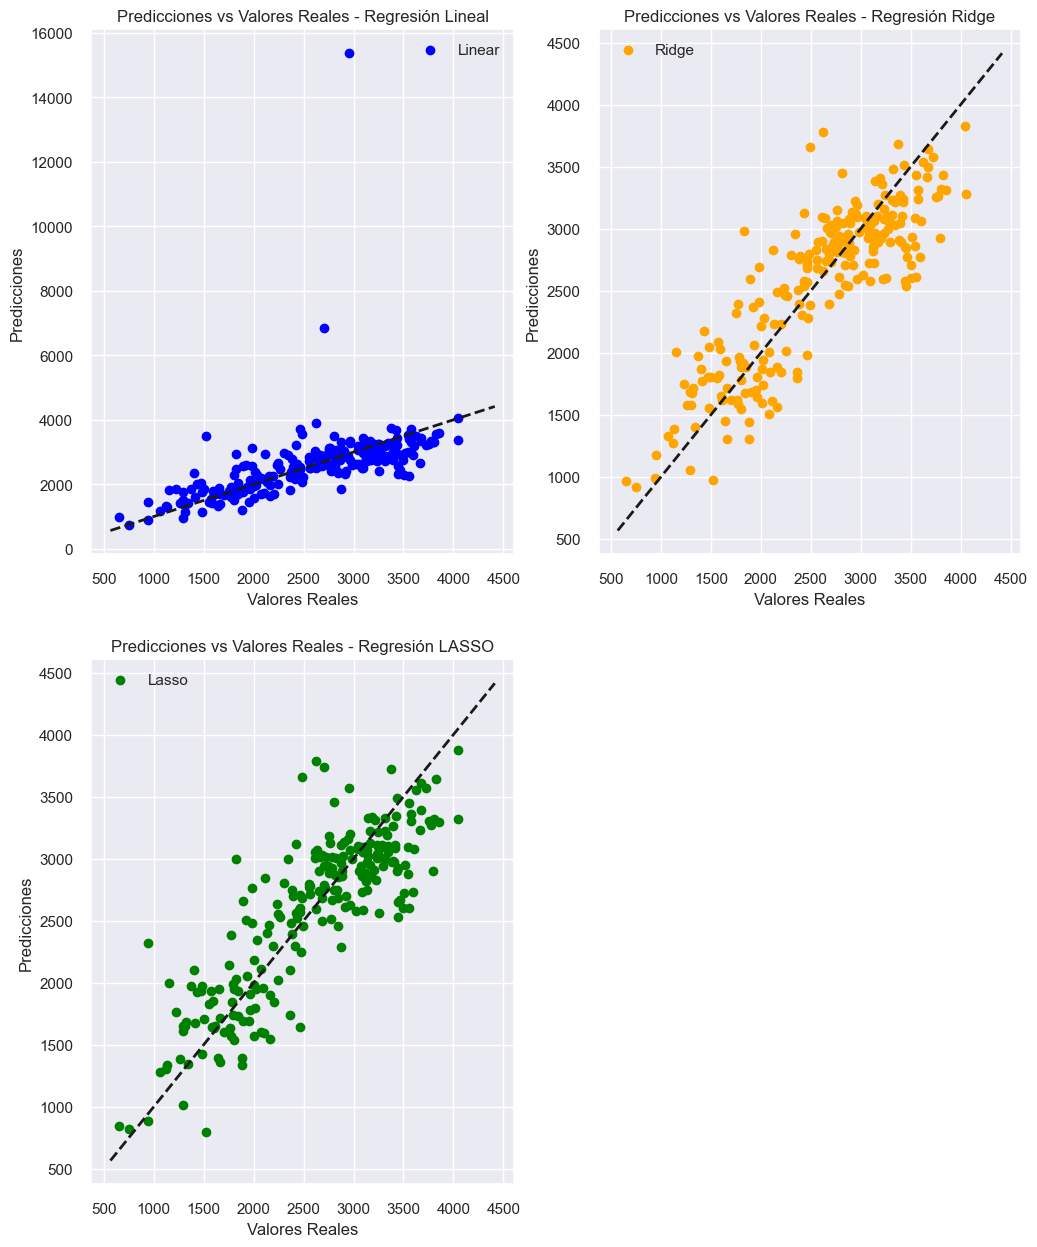

In [56]:
plt.figure(figsize=(12,15))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión Lineal')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_ridge, color='orange', label='Ridge')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión Ridge')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_lasso, color='green', label='Lasso')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión LASSO')
plt.legend()

plt.show()

Si nos fijamos en la representación de las predicciones respecto a los valores reales, observamos que el modelo de regresión lineal simple tiene algunos valores predichos extremadamente altos. Esto nos podria estar indicando un sobreajuste. Vemos que el modelo de regresión lineal no generaliza bien, que podria deberse a la falta de regularización del limite de los coeficientes.

El segundo grafico corresponde a Ridge. Vemos que las predicciones se distribuyen más cerca de la línea diagonal. Esto nos indica que tenemos una mejor precisión en el modelo. Al tratarse de un metodo regularizado, se ha reducido el impacto de los valores extremos, con lo que las predicciones estan más ajustadas al valor real.

Por ultimo tenemos a Lasso, este modelo tiene un resultado similar a Ridge. Las predicciones siguen ciñendose más a la linea diagonal que con el modelo de regresión lineal simple. Debido a la regularizacion de Lasso podemos observar que no hay valores extremadamente altos. Ademas Lasso tiende a llevar algunos coeficientes a 0, eliminado algunas variables.

### RESIDUOS

<Figure size 1200x1500 with 0 Axes>

<Axes: >

<Axes: xlabel='Sanciones-Numero', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de Residuos')

Text(0.5, 0, 'Residuos')

Text(0, 0.5, 'Frecuencia')

<Axes: >

<Axes: xlabel='Sanciones-Numero', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de Residuos')

Text(0.5, 0, 'Residuos')

Text(0, 0.5, 'Frecuencia')

<Axes: >

<Axes: xlabel='Sanciones-Numero', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de Residuos')

Text(0.5, 0, 'Residuos')

Text(0, 0.5, 'Frecuencia')

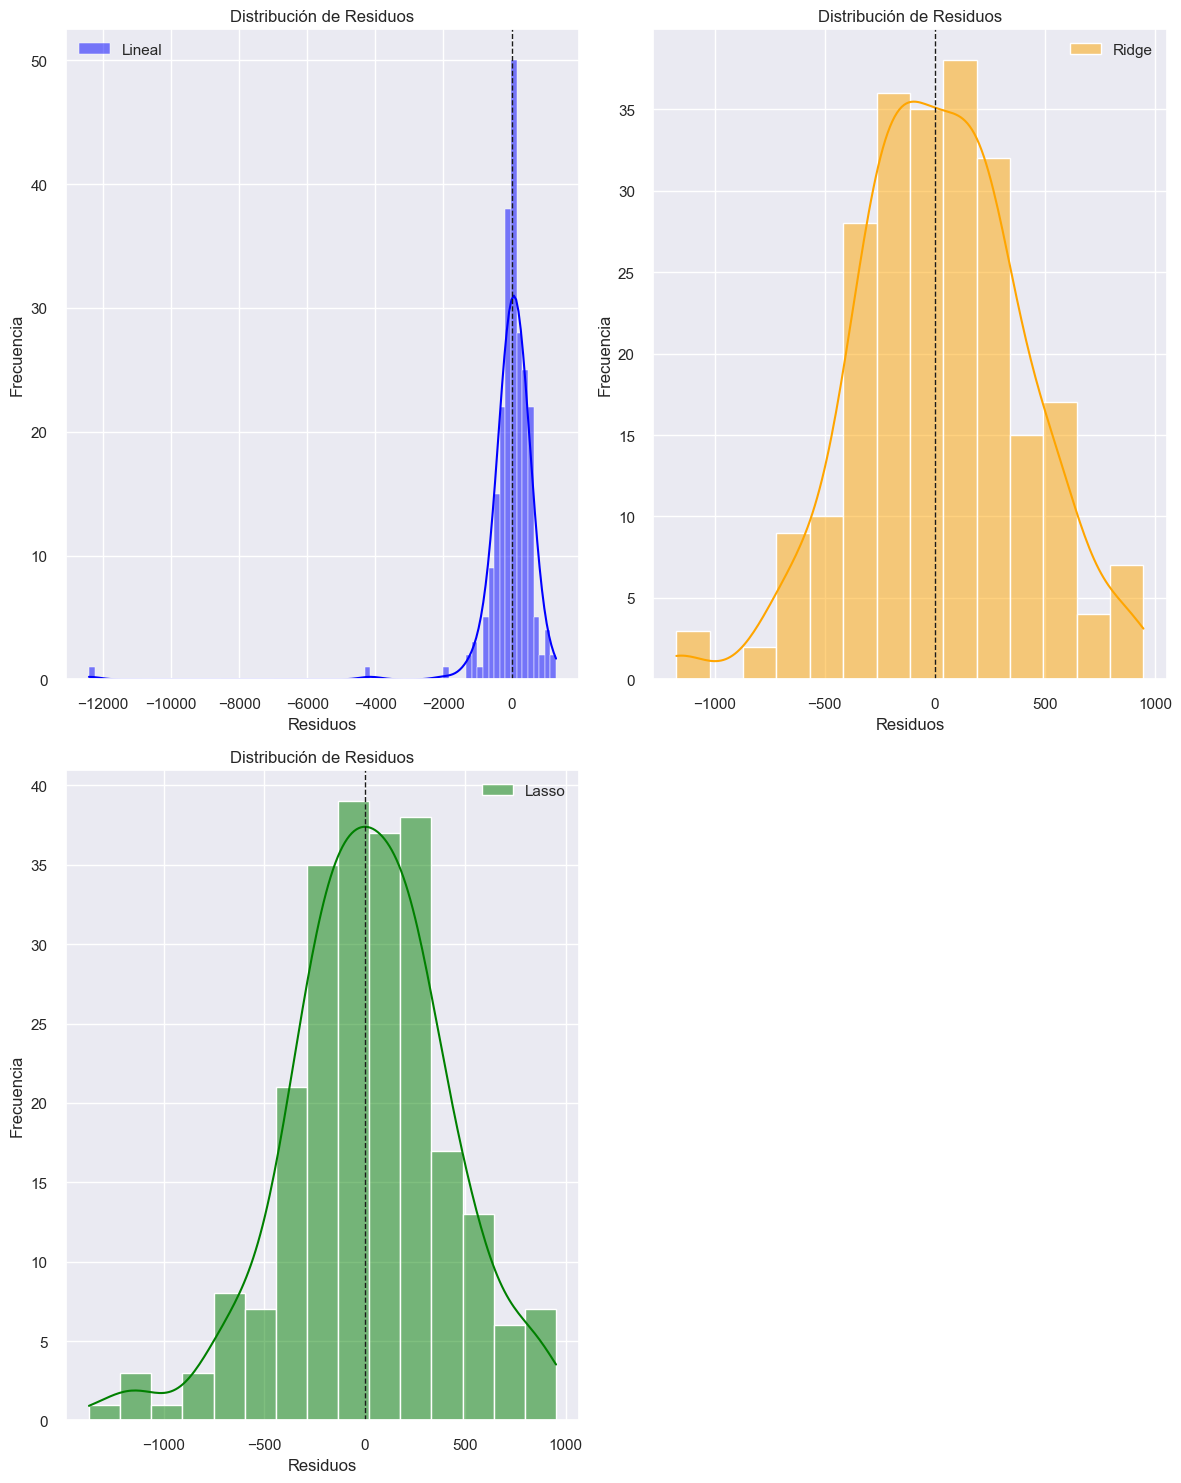

In [57]:
residuals_linear = y_test - y_pred_linear
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(12,15))
plt.subplot(2, 2, 1)
sns.histplot(residuals_linear, kde=True, color='blue', label='Lineal', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(residuals_ridge, kde=True, color='orange', label='Ridge', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(2, 2, 3)
sns.histplot(residuals_lasso, kde=True, color='green', label='Lasso', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

La distribucion de los errores observamos que sigue una distribución normal igaul que en apartados anteriores. Parece que los valores centrales se han normalizado más pero tanto en Ridge como en Lasso las colas podrian tener algun valor extremo. 

En el caso de la regresión lineal simple vemos que tiene en la parte izquierda una cola muy grande y exagerada debido a los valores extremos que hemos comentado antes.

<Figure size 400x400 with 0 Axes>

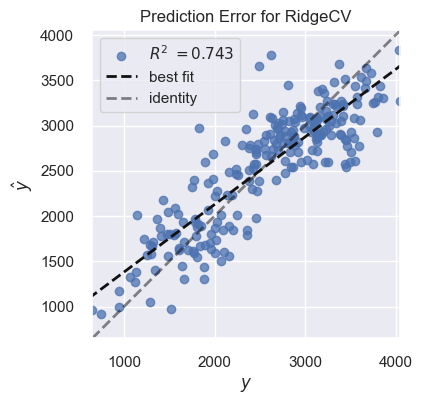

<Figure size 1000x1000 with 0 Axes>

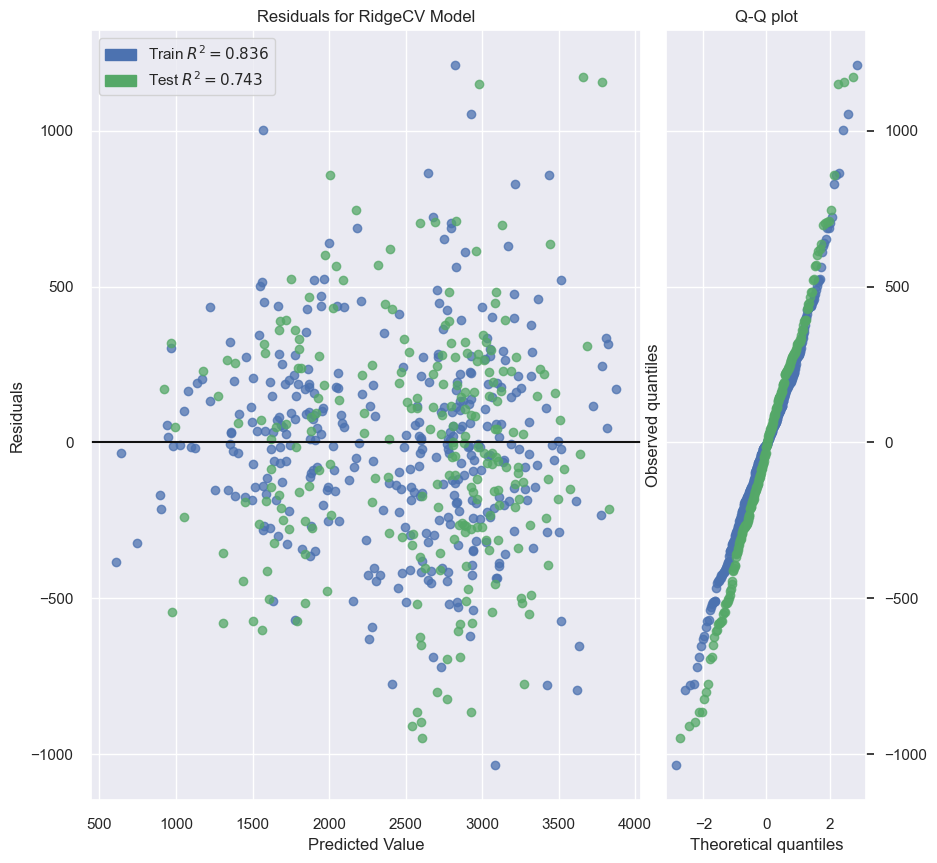

In [58]:
from yellowbrick.regressor import residuals_plot, prediction_error
plt.figure(figsize=(4,4))
visualizer = prediction_error(ridge_cv, X_test_poly, y_test, is_fitted=True)

plt.figure(figsize=(10,10))
viz = residuals_plot(ridge_cv, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False)

Al observar los plots superiores vemos que Ridge muestra una buena capacidad de generalización con un R2 alto tanto en los datos de entrenamiento como en los de prueba. Los residuois se agrupan entorno al 0 siguiendo una distribución normal, con algunos valores atipicos per no muchos. En el Q-Q los residuos se ajustan bien aunque en las colas vemos algun valor atipico pero como hemos dicho sigue una distribucion normal. Si nos fijamos en el grafico de prediction error, ahora la recta best fit esta más cerca de la identidad ya que con las nuevas variables hemos mejorado el modelo.

<Figure size 400x400 with 0 Axes>

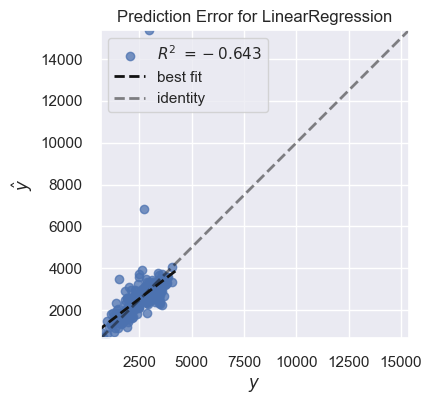

<Figure size 1000x1000 with 0 Axes>

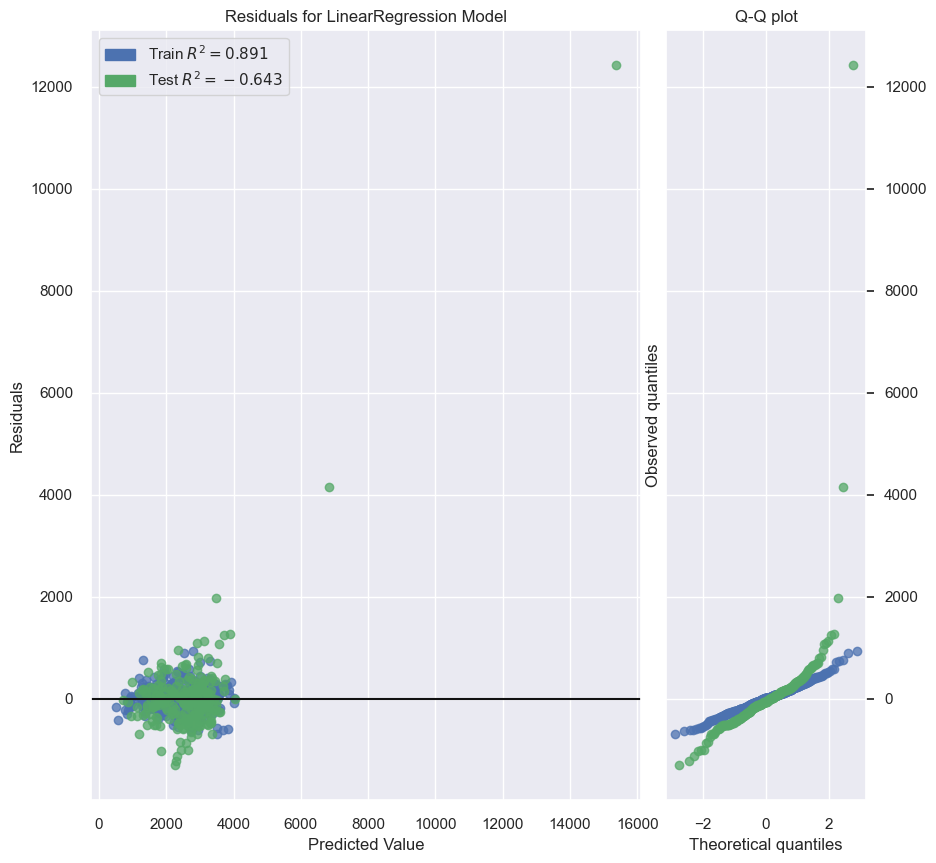

In [59]:
from yellowbrick.regressor import residuals_plot, prediction_error
plt.figure(figsize=(4,4))
visualizer = prediction_error(linear_model, X_test_poly, y_test, is_fitted=True)

plt.figure(figsize=(10,10))
viz = residuals_plot(linear_model, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False)

De lo primero que nos damos cuenta al observar el grafico para la regresión lineal simple es que no genraliza bien. Mientras que con los datos de entrenamiento obtenemos muy buenos resultados, con los datos de test no tanto, sugieriendo que el modelo hace overfittin y que con datos nuevos no funciona bien. Ademas tenemos valores atipicos muy extremos. En el grafico Q-Q tambien vemos que la distribución es extraña con unas colas muy desviadas.

<Figure size 400x400 with 0 Axes>

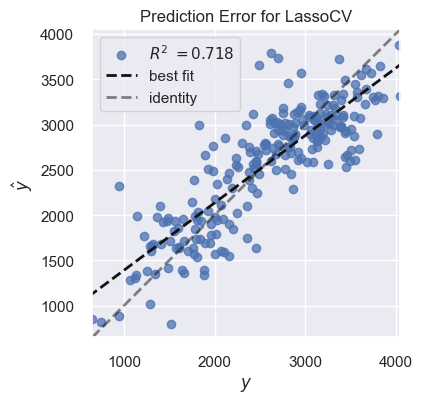

<Figure size 1000x1000 with 0 Axes>

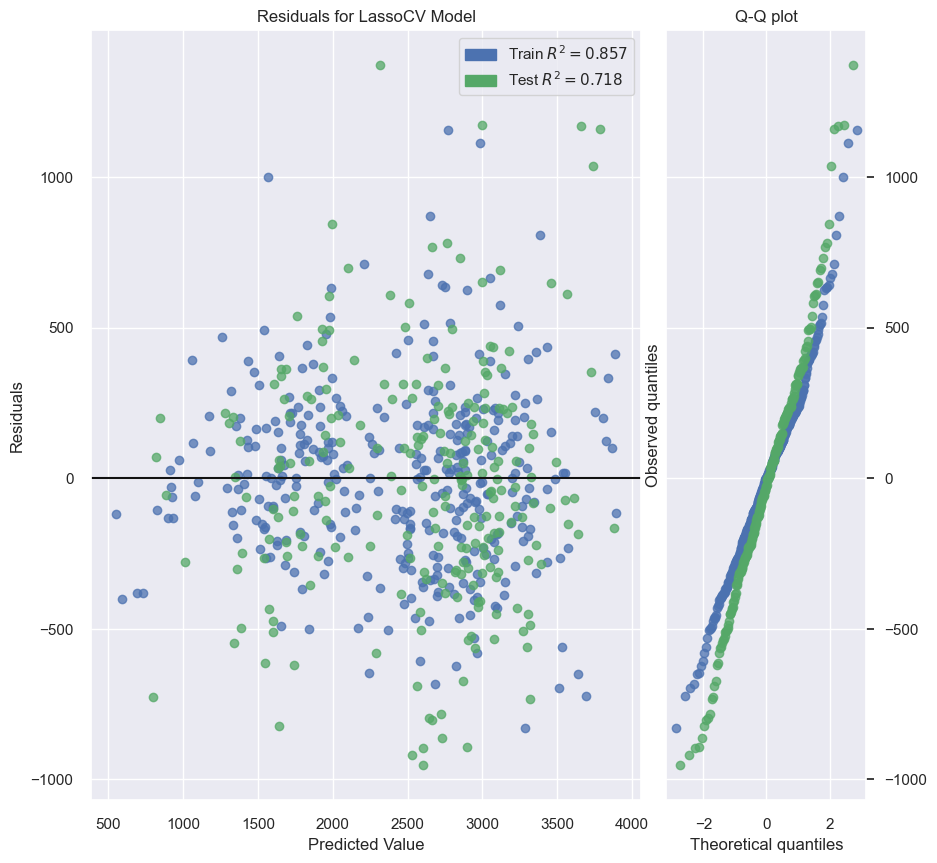

In [60]:
from yellowbrick.regressor import residuals_plot, prediction_error
plt.figure(figsize=(4,4))
visualizer = prediction_error(lasso_cv, X_test_poly, y_test, is_fitted=True)

plt.figure(figsize=(10,10))
viz = residuals_plot(lasso_cv, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False)

Con Lasso vemos resultados similares a los de Ridge. Los resifuos se distribuyen alrededor del 0 y el Q-Q plot sigue una distribución normal, con alguna desviacion en las colas pero mas controlada. La linea de best fit del grafico de prediction error se ha ajustado más a la recta identidad en comparación con el resultado del apartado b.

En conclusión al añadir nuevas varibales usando la función PolynomialFeatures, hemos conseguido usando los modelos de Ridge y de Lasso mejorar los resultados que habiamos obtenido con las variables originales. En cambio con la regresion lineal simple no nos ha funcionada igual y los resultados han sido mucho peores. Este puede deberse a la regularización de los coeficientes que hacen Ridge y Lasso. Si tuviera que quedarme con un modelo me quedaria con Ridge o con Lasso usando las nuevas variables que hemos creado en este ultimo apartado